# Sparse

SELECT and PREPARE for the second quantized sparse chemistry Hamiltonian.

Starting from the traditional second quantized chemistry Hamiltonian
$$
H = \sum_\sigma \sum_{pq} T_{pq} a_{p\sigma}^\dagger a_{q\sigma}
+
\frac{1}{2}\sum_{\alpha\beta}
\sum_{pqrs}
V_{pqrs} a_{p\sigma}^\dagger a_{r\beta}^\dagger a_{s\beta} a_{q\alpha},
$$
where $a_{p\sigma}$ ($a_{q\sigma}^\dagger$) annihilate (create) an electron in the
$p$-th orbital of spin $\sigma$.
We can rewrite this expression using the Jordan-Wigner transformation as
$$
H = T' + V',
$$
where
$$
T' = \frac{1}{2} \sum_\sigma \sum_{pq} T_{pq}'Q_{pq\sigma},
$$
$$
V' = \sum_{\alpha\beta}\sum_{pqrs}V_{pqrs}Q_{pq\alpha}Q_{rs\beta},
$$
and $V = (pq|rs)$ are the usual two-electron integrals in chemist's notation,
$$
T'_{pq} = T_{pq} - \sum_r V_{pqrr},
$$
and
$$
Q_{pq\sigma} =
\begin{cases}
X_{p\sigma}\vec{Z}X_{q\sigma} & p < q \\
Y_{p\sigma}\vec{Z}Y_{q\sigma} & p > q \\
-Z_{p\sigma} & p = q
\end{cases}.
$$
The sparse Hamiltonian simply sets to zero any term in the Hamiltonian where
$|V_{pqrs}|$ is less than some threshold. This reduces the
amount of data that is required to be loaded during state preparation as only
non-zero symmetry inequivalent terms are required (the two electron integrals
exhibit 8-fold permutational symmetry). Symmetries are restored by initially
appropriately weighting these non-zero terms and then using $|+\rangle$ states
to perform control swaps between the $pqrs$ registers.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `PrepareSparse`
Prepare oracle for the sparse chemistry Hamiltonian

Prepare the state:

$$
    |0\rangle|+\rangle|0\rangle|0\rangle
    \sum_{\sigma}\sum_{pq}
    \sqrt{\frac{T_{pq}'}{2\lambda}}
    |\theta_{pq}^T\rangle|pq\sigma\rangle|000\rangle
    +|1\rangle|+\rangle|+\rangle|+\rangle
    \sum_{\alpha\beta}
    \sum_{pqrs}
    \sqrt{\frac{\tilde{V}_{pqrs}'}{2\lambda}}
    |\theta_{pqrs}^V\rangle|pq\alpha\rangle|rs\beta\rangle
$$

#### Parameters
 - `num_spin_orb`: The number of spin orbitals.
 - `num_non_zero`: The number of non-zero matrix elements.
 - `num_bits_state_prep`: the number of bits of precision for state preparation. This will control the size of the keep register.
 - `num_bits_rot_aa`: The number of bits of precision for the single-qubit rotation for amplitude amplification during the uniform state preparation. Default 8.
 - `adjoint`: Whether we are apply PREPARE or PREPARE^dag
 - `qroam_block_size`: qroam blocking factor. 

#### Registers
 - `d`: the register indexing non-zero matrix elements.
 - `pqrs`: the register to store the spatial orbital index.
 - `sigma`: the register prepared for alias sampling.
 - `alpha`: spin for (pq) indicies.
 - `beta`: spin for (rs) indicies.
 - `rot_aa`: the qubit rotated for amplitude amplification.
 - `swap_pq`: a |+> state to restore the symmetries of the p and q indices.
 - `swap_rs`: a |+> state to restore the symmetries of the r and s indices.
 - `swap_pqrs`: a |+> state to restore the symmetries of between (pq) and (rs).
 - `theta`: sign qubit.
 - `alt_pqrs`: the register to store the alternate values for the spatial orbital indices.
 - `theta`: A two qubit register for the sign bit and it's alternate value.
 - `keep`: The register containing the keep values for alias sampling.
 - `less_than`: A single qubit for the result of the inequality test during alias sampling.
 - `flag_1b`: a single qubit register indicating whether to apply only the one-body SELECT.
 - `alt_flag_1b`: alternate value for flag_1b 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        hypercontraction](https://arxiv.org/abs/2011.03494) Eq. A11.

In [2]:
from qualtran.bloqs.chemistry.sparse.prepare import PrepareSparse

### Example Instances

In [3]:
num_spin_orb = 4
tpq = np.random.random((num_spin_orb // 2, num_spin_orb // 2))
tpq = 0.5 * (tpq + tpq.T)
eris = np.random.random((num_spin_orb // 2,) * 4)
eris += np.transpose(eris, (0, 1, 3, 2))
eris += np.transpose(eris, (1, 0, 2, 3))
eris += np.transpose(eris, (2, 3, 0, 1))
prep_sparse = PrepareSparse.from_hamiltonian_coeffs(num_spin_orb, tpq, eris)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([prep_sparse],
           ['`prep_sparse`'])

### Call Graph

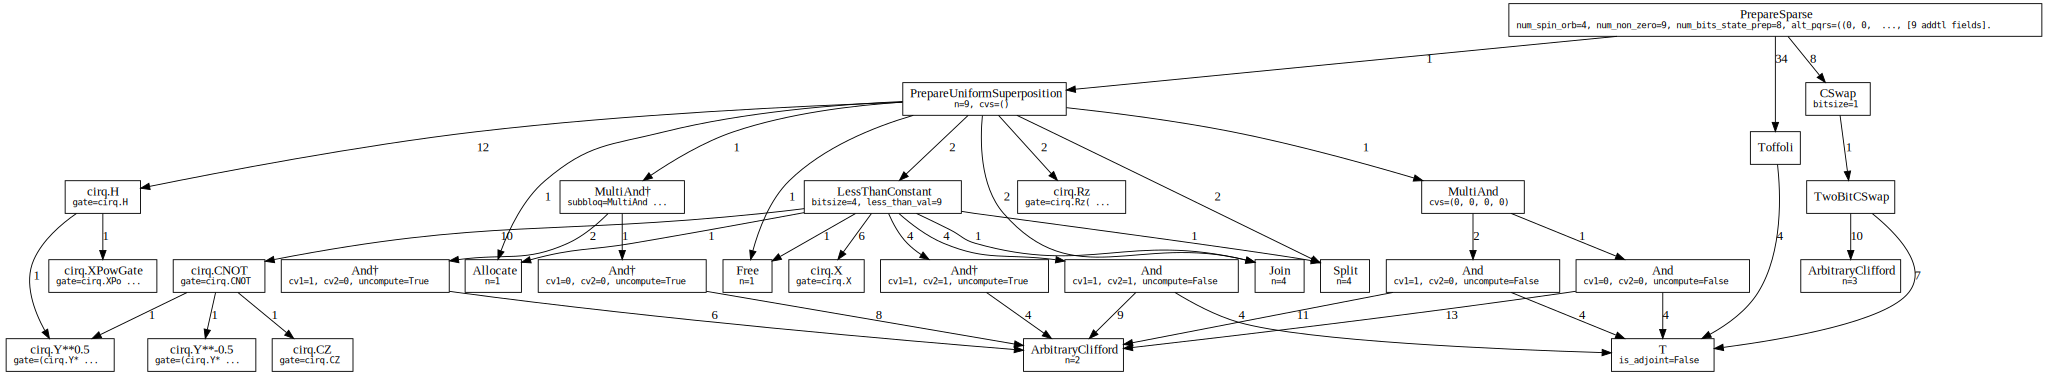

#### Counts totals:
 - `Allocate(n=1)`: 3
 - `ArbitraryClifford(n=2)`: 159
 - `ArbitraryClifford(n=3)`: 80
 - `CZ`: 20
 - `Free(n=1)`: 3
 - `Join(n=4)`: 4
 - `Rz(0.46455905439753997π)`: 2
 - `Split(n=4)`: 4
 - `TGate()`: 236
 - `XPowGate(exponent=1.0, global_shift=-0.25)`: 12
 - `X`: 12
 - `Y**-0.5`: 20
 - `Y**0.5`: 32

In [5]:
prep_sparse_g, prep_sparse_sigma = prep_sparse.call_graph()
show_call_graph(prep_sparse_g)
show_counts_sigma(prep_sparse_sigma)

## `SelectSparse`
SELECT oracle for the sparse Hamiltonian.

Implements the two applications of Fig. 13.

#### Parameters
 - `num_spin_orb`: The number of spin orbitals. Typically called N. 

#### Registers
 - `flag_1b`: a single qubit to flag whether the one-body Hamiltonian is to be applied or not during SELECT.
 - `swap_pq`: a |+> state to restore the symmetries of the p and q indices.
 - `swap_rs`: a |+> state to restore the symmetries of the r and s indices.
 - `swap_pqrs`: a |+> state to restore the symmetries of between (pq) and (rs).
 - `theta`: sign qubit.
 - `pqrs`: the register to store the spatial orbital index.
 - `alpha`: spin for (pq) indicies.
 - `beta`: spin for (rs) indicies. 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        hypercontraction](https://arxiv.org/abs/2011.03494) Fig 13.

In [6]:
from qualtran.bloqs.chemistry.sparse.select_bloq import SelectSparse

### Example Instances

In [7]:
num_spin_orb = 4
sel_sparse = SelectSparse(num_spin_orb)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([sel_sparse],
           ['`sel_sparse`'])

### Call Graph

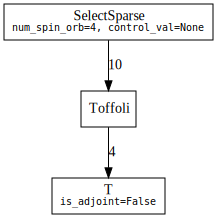

#### Counts totals:
 - `TGate()`: 40

In [9]:
sel_sparse_g, sel_sparse_sigma = sel_sparse.call_graph()
show_call_graph(sel_sparse_g)
show_counts_sigma(sel_sparse_sigma)